In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/output-v2/output_v2.xlsx


In [74]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import time
import csv
import math
import os

import random
import seaborn as sns
import statsmodels.tsa.stattools as ts

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

In [75]:
data = pd.read_excel('/kaggle/input/output-v2/output_v2.xlsx',
sheet_name=0,
header=0,
index_col=[0],
keep_default_na=True
)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


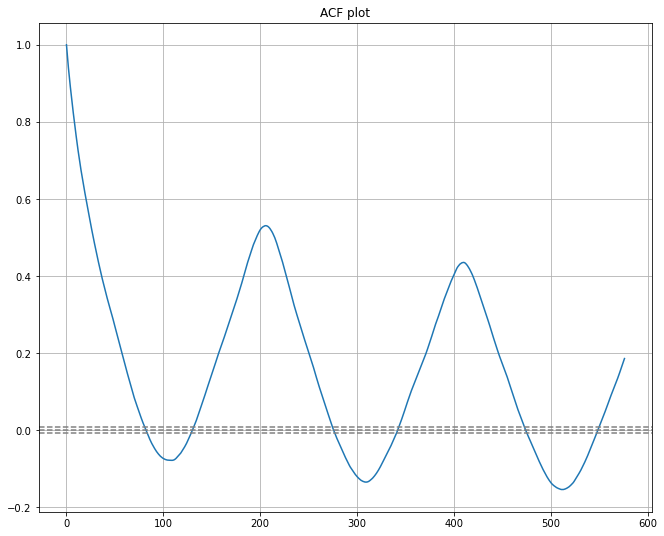

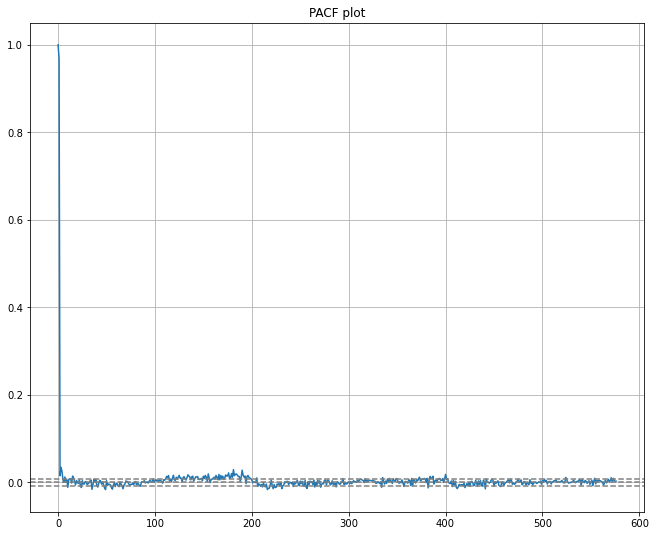

In [76]:
from statsmodels.tsa.stattools import acf,pacf 
ac=acf(data['label'],nlags=12*12*4,unbiased=True)
pac=pacf(data['label'],nlags=12*12*4)
plt.figure(figsize=(11,9))
plt.title('ACF plot')
plt.grid()
plt.plot(ac)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.figure(figsize=(11,9))
plt.title('PACF plot')
plt.grid()
plt.plot(pac)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
plt.show()

In [77]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort_values
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    
    return df_copy

In [101]:
autocorrs = pd.Series(ac)
list_of_regressors = autocorrs.loc[autocorrs > 0.3].index
list_of_regressors = list_of_regressors[111:200]
list_of_regressors

Int64Index([], dtype='int64')

In [79]:
cons = data.loc[:, [ 'label']]
df_consum = create_regressor_attributes(cons, ['label'], list_of_regressors)


In [80]:
print(df_consum)

                     label  label_(t-199)  label_(t-200)  label_(t-201)  \
datetime                                                                  
2015-01-06 06:45:00    0.0       0.000000       0.000000       0.000000   
2015-01-06 06:50:00    0.0       0.000000       0.000000       0.000000   
2015-01-06 06:55:00    0.0       0.000000       0.000000       0.000000   
2015-01-06 07:00:00    0.0       0.000000       0.000000       0.000000   
2015-01-06 07:05:00    0.0       0.000000       0.000000       0.000000   
...                    ...            ...            ...            ...   
2015-12-29 22:40:00    0.0       0.011733       0.011733       0.017733   
2015-12-29 22:45:00    0.0       0.011733       0.011733       0.011733   
2015-12-29 22:50:00    0.0       0.011733       0.011733       0.011733   
2015-12-29 22:55:00    0.0       0.011733       0.011733       0.011733   
2015-12-29 23:00:00    0.0       0.011733       0.011733       0.011733   

                     lab

In [81]:
def train_test_valid_split_plus_scaling(df, valid_set_size, test_set_size):
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    
    df_copy = df.reset_index(drop=True)
    
    df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
    df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

    df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
    df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


    X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
    X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
    X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]
    
    global Target_scaler
    
    Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
    Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
    
    X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
    X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
    X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))
    
    y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
    y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
    y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))
    
    print('Shape of training inputs, training target:', X_train_scaled.shape, y_train_scaled.shape)
    print('Shape of validation inputs, validation target:', X_valid_scaled.shape, y_valid_scaled.shape)
    print('Shape of test inputs, test targets:', X_test_scaled.shape, y_test_scaled.shape)

    return X_train_scaled, X_valid_scaled, X_test_scaled, y_train_scaled, y_valid_scaled, y_test_scaled

In [82]:
valid_set_size = 0.3
test_set_size = 0.3
X_train, X_valid, X_test, y_train, y_valid, y_test = train_test_valid_split_plus_scaling(df_consum, 
                                                                                         valid_set_size, 
                                                                                        test_set_size)

Shape of training inputs, training target: (25710, 16) (25710, 1)
Shape of validation inputs, validation target: (11019, 16) (11019, 1)
Shape of test inputs, test targets: (15742, 16) (15742, 1)


In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_valid=scaler.fit_transform(X_valid)
X_test=scaler.fit_transform(X_test)
y_train=scaler.fit_transform(y_train)
y_valid=scaler.fit_transform(y_valid)
y_test=scaler.fit_transform(y_test)

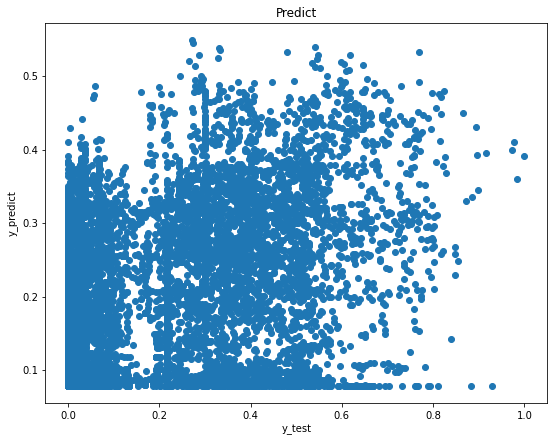

In [84]:
# Regression 
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(X_train,y_train)
yhat=reg.predict(X_test)
plt.figure(figsize=(9,7))
plt.scatter(y_test,yhat)
plt.xlabel('y_test')
plt.ylabel('y_predict')
plt.title('Predict')
plt.show()

r2_score for Linear regression is 0.256443
MSE for Linear Regression is 0.027670


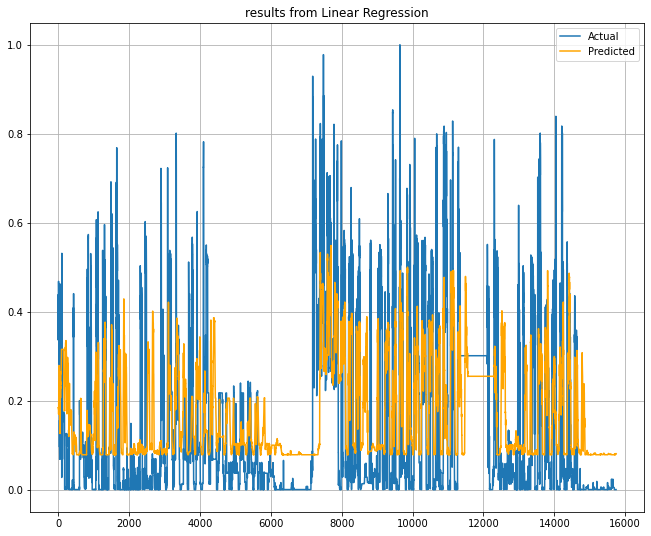

In [85]:
print('r2_score for Linear regression is %4f'%r2_score(y_test,yhat))
print('MSE for Linear Regression is %4f'%mean_squared_error(y_test,yhat))
plt.figure(figsize=(11,9))
plt.plot(y_test,label='Actual')
plt.plot(yhat,color='orange',label='Predicted')
plt.grid('Bold')
plt.legend(loc='best')
plt.title('results from Linear Regression')
plt.show()